In [12]:
import argparse
import logging
import time
import random
import datetime
import tqdm
from os.path import exists
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
import torch.optim as optim

import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import affine_autoregressive
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceEnum_ELBO, TraceTMC_ELBO, config_enumerate
from pyro.optim import ClippedAdam

import ot
import torch.nn.functional as F

import mido
from mido import Message, MidiFile, MidiTrack, MetaMessage

from midi2audio import FluidSynth

import pretty_midi
from scipy.io import wavfile

import musics

In [2]:
N_data=10
length = 20
A = torch.randn(100,100) / 10
# A = torch.zeros(100,100)
B = torch.randn(100,100)
C = torch.randn(100) /10
x = torch.zeros(N_data, length, 1)
for i in range(N_data):
    z = torch.zeros(100)
    for j in range(length-1):
        z = torch.mv(A, z) + torch.mv(B, torch.randn(100))
        x[i][j+1] = torch.dot(C, z)

print(x.size())
print(x)

torch.Size([10, 20, 1])
tensor([[[  0.0000],
         [ -6.3540],
         [-10.5024],
         [-22.8427],
         [-28.5545],
         [ -2.5055],
         [-19.2603],
         [-37.8907],
         [-17.9124],
         [-29.3071],
         [ 23.3063],
         [ -0.9793],
         [ -1.8633],
         [-23.7825],
         [-33.0284],
         [ 33.9804],
         [ 54.6859],
         [ 43.0495],
         [ 30.2825],
         [-34.7848]],

        [[  0.0000],
         [ -6.3524],
         [-13.3222],
         [ 20.5672],
         [ 49.8948],
         [-10.1994],
         [-31.2018],
         [-11.2829],
         [ -1.4710],
         [  6.2383],
         [-13.3394],
         [-25.2854],
         [ -2.6531],
         [-18.9585],
         [ 59.1311],
         [ 15.5393],
         [-17.5904],
         [-30.1927],
         [ 25.6735],
         [ 60.2325]],

        [[  0.0000],
         [ -8.1686],
         [ -8.4539],
         [ 24.7176],
         [ 23.3257],
         [ 15.8551],
      

# Class and Def

In [3]:
class Emitter(nn.Module):
    """
    Parameterizes the bernoulli observation likelihood `p(x_t | z_t)`
    """

    def __init__(self, input_dim, z_dim, emission_dim, use_cuda=False):
        super().__init__()
        self.input_dim = input_dim
        self.use_cuda = use_cuda
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, emission_dim)
        self.lin_hidden_to_hidden = nn.Linear(emission_dim, emission_dim)
        self.lin_hidden_to_input = nn.Linear(emission_dim, input_dim)
        # initialize the two non-linearities used in the neural network
        self.relu = nn.ReLU()

    def forward(self, z_t):
        """
        Given the latent z at a particular time step t we return the vector of
        probabilities `ps` that parameterizes the bernoulli distribution `p(x_t|z_t)`
        """
        h1 = self.relu(self.lin_z_to_hidden(z_t))
        h2 = self.relu(self.lin_hidden_to_hidden(h1))
        if self.input_dim == 1:
            x = self.lin_hidden_to_input(h2)
        else:
            ps = torch.sigmoid(self.lin_hidden_to_input(h2))

            #Reparameterization Trick
            if self.use_cuda: 
                eps = torch.rand(self.input_dim).cuda()
            else : eps = torch.rand(self.input_dim)
            # assert len(emission_probs_t) == 88
            appxm = torch.log(eps + 1e-20) - torch.log(1-eps + 1e-20) + torch.log(ps + 1e-20) - torch.log(1-ps + 1e-20)
            # appxm = torch.log(eps) - torch.log(1-eps) + torch.log(x) - torch.log(1-x)
            x = torch.sigmoid(appxm)
        return x

class GatedTransition(nn.Module):
    """
    Parameterizes the gaussian latent transition probability `p(z_t | z_{t-1})`
    See section 5 in the reference for comparison.
    """

    def __init__(self, z_dim, transition_dim):
        super().__init__()
        # initialize the six linear transformations used in the neural network
        self.lin_gate_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, transition_dim)
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, z_dim)
        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)
        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the identity function
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)
        # initialize the three non-linearities used in the neural network
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1):
        """
        Given the latent `z_{t-1}` corresponding to the time step t-1
        we return the mean and scale vectors that parameterize the
        (diagonal) gaussian distribution `p(z_t | z_{t-1})`
        """
        # compute the gating function
        _gate = self.relu(self.lin_gate_z_to_hidden(z_t_1))
        gate = torch.sigmoid(self.lin_gate_hidden_to_z(_gate))
        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(z_t_1))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)
        # assemble the actual mean used to sample z_t, which mixes a linear transformation
        # of z_{t-1} with the proposed mean modulated by the gating function
        loc = (1 - gate) * self.lin_z_to_loc(z_t_1) + gate * proposed_mean
        # compute the scale used to sample z_t, using the proposed mean from
        # above as input the softplus ensures that scale is positive
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))
        # return loc, scale which can be fed into Normal
        return loc, scale

class Combiner(nn.Module):
    """
    Parameterizes `q(z_t | z_{t-1}, x_{t:T})`, which is the basic building block
    of the guide (i.e. the variational distribution). The dependence on `x_{t:T}` is
    through the hidden state of the RNN (see the PyTorch module `rnn` below)
    """

    def __init__(self, z_dim, rnn_dim):
        super().__init__()
        # initialize the three linear transformations used in the neural network
        self.lin_z_to_hidden = nn.Linear(z_dim, rnn_dim)
        self.lin_hidden_to_loc = nn.Linear(rnn_dim, z_dim)
        self.lin_hidden_to_scale = nn.Linear(rnn_dim, z_dim)
        # initialize the two non-linearities used in the neural network
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1, h_rnn):
        """
        Given the latent z at at a particular time step t-1 as well as the hidden
        state of the RNN `h(x_{t:T})` we return the mean and scale vectors that
        parameterize the (diagonal) gaussian distribution `q(z_t | z_{t-1}, x_{t:T})`
        """
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.lin_z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state to compute the mean used to sample z_t
        loc = self.lin_hidden_to_loc(h_combined)
        # use the combined hidden state to compute the scale used to sample z_t
        scale = self.softplus(self.lin_hidden_to_scale(h_combined))
        # return loc, scale which can be fed into Normal
        return loc, scale

class Encoder(nn.Module):
    def __init__(self, input_dim=88, z_dim=100,rnn_dim=60, num_layers=1, rnn_dropout_rate=0.1,num_iafs=0, iaf_dim=50, N_z0 = 10, use_cuda=False, rnn_check=False):
        super().__init__()
        # instantiate PyTorch modules used in the model and guide below
        self.combiner = Combiner(z_dim, rnn_dim)
        # dropout just takes effect on inner layers of rnn
        rnn_dropout_rate = 0. if num_layers == 1 else rnn_dropout_rate
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=rnn_dim, nonlinearity='relu',
                          batch_first=True, bidirectional=False, num_layers=num_layers,
                          dropout=rnn_dropout_rate)

        # if we're using normalizing flows, instantiate those too
        # self.iafs = [affine_autoregressive(z_dim, hidden_dims=[iaf_dim]) for _ in range(num_iafs)]
        # self.iafs_modules = nn.ModuleList(self.iafs)

        # define a (trainable) parameters z_0 and z_q_0 that help define the probability
        # distributions p(z_1) and q(z_1)
        # (since for t = 1 there are no previous latents to condition on)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))

        # randnでやっても失敗した。やっぱりいけた。学習率が問題？
        # onesでやってみる 訓練データ1つならOK
        # self.z_0 = nn.Parameter(torch.randn(z_dim))
        # self.z_q_0 = nn.Parameter(torch.randn(z_dim))
        
        # self.z_0 = nn.Parameter(torch.randn(N_z0, z_dim))
        # self.z_q_0 = nn.Parameter(torch.randn(N_z0, z_dim))

        # define a (trainable) parameter for the initial hidden state of the rnn
        self.h_0 = nn.Parameter(torch.randn(1, 1, rnn_dim))

        self.use_cuda = use_cuda
        # if on gpu cuda-ize all PyTorch (sub)modules
        if use_cuda:
            self.cuda()

        self.rnn_check = rnn_check

    def forward(self, mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths, annealing_factor=1.0):

        # this is the number of time steps we need to process in the mini-batch
        T_max = mini_batch.size(1)

        # if on gpu we need the fully broadcast view of the rnn initial state
        # to be in contiguous gpu memory
        h_0_contig = self.h_0.expand(1, mini_batch.size(0), self.rnn.hidden_size).contiguous()
        # if any(torch.isnan(h_0_contig.reshape(-1))):
        #     for param in self.rnn.parameters():
        #         print(param)
        #     assert False
        # push the observed x's through the rnn;
        # rnn_output contains the hidden state at each time step
        rnn_output, _ = self.rnn(mini_batch_reversed, h_0_contig)
        # if True:
        #     if any(torch.isnan(rnn_output.data.reshape(-1))):
        #         assert False

        # reverse the time-ordering in the hidden state and un-pack it
        rnn_output = poly.pad_and_reverse(rnn_output, mini_batch_seq_lengths)

        # set z_prev = z_q_0 to setup the recursive conditioning in q(z_t |...)
        z_prev = self.z_q_0.expand(mini_batch.size(0), self.z_q_0.size(0))
        # z_prev = self.z_q_0.expand(mini_batch.size(0), self.z_q_0.size(0))
        # z_prev = self.z_q_0

        # if any(torch.isnan(z_prev.reshape(-1))):
        #     print("z_prev")

        z_container = []
        z_loc_container = []
        z_scale_container = []
        for t in range(1,T_max+1):
            # the next two lines assemble the distribution q(z_t | z_{t-1}, x_{t:T})
            z_loc, z_scale = self.combiner(z_prev, rnn_output[:, t - 1, :])
            z_scale = torch.clamp(z_scale, min = 0.1)
            # Reparameterization Trick
            if self.use_cuda:
                eps = torch.randn(z_loc.size()).cuda()
            else: eps = torch.randn(z_loc.size())
            z_t = z_loc + z_scale * eps

            # the latent sampled at this time step will be conditioned upon
            # in the next time step so keep track of it
            z_prev = z_t
            z_container.append(z_t)
            z_loc_container.append(z_loc)
            z_scale_container.append(z_scale)
        
        z_container = torch.stack(z_container)
        z_loc_container = torch.stack(z_loc_container)
        z_scale_container = torch.stack(z_scale_container)
        return z_container.transpose(0,1), z_loc_container.transpose(0,1), z_scale_container.transpose(0,1)

class Prior(nn.Module):
    def __init__(self, z_dim=100, transition_dim=200,  N_z0 = 10, use_cuda=False):
        super().__init__()
        # instantiate PyTorch modules used in the model and guide below
        self.trans = GatedTransition(z_dim, transition_dim)

        # define a (trainable) parameters z_0 and z_q_0 that help define the probability
        # distributions p(z_1) and q(z_1)
        # (since for t = 1 there are no previous latents to condition on)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))

        # self.z_0 = nn.Parameter(torch.randn(z_dim))
        # self.z_q_0 = nn.Parameter(torch.randn(z_dim))
        
        # self.z_0 = nn.Parameter(torch.randn(N_z0, z_dim))
        # self.z_q_0 = nn.Parameter(torch.randn(N_z0, z_dim))

        self.use_cuda = use_cuda
        # if on gpu cuda-ize all PyTorch (sub)modules

    def forward(self, length, N_generate):

        # this is the number of time steps we need to process in the mini-batch
        T_max = length

        # set z_prev = z_q_0 to setup the recursive conditioning in q(z_t |...)
        z_prev = self.z_q_0.expand(N_generate, self.z_q_0.size(0))
        # z_prev = self.z_q_0.expand(N_generate, self.z_q_0.size(0))
        # z_prev = self.z_q_0

        # if any(torch.isnan(z_prev.reshape(-1))):
        #     print("z_prev")

        z_container = []
        z_loc_container = []
        z_scale_container = []
        for t in range(1,T_max+1):
            # the next two lines assemble the distribution q(z_t | z_{t-1}, x_{t:T})
            z_loc, z_scale = self.trans(z_prev)
            z_scale = torch.clamp(z_scale, min = 0.1)

            # Reparameterization Trick
            if self.use_cuda:
                eps = torch.randn(z_loc.size()).cuda()
            else: eps = torch.randn(z_loc.size())
            z_t = z_loc + z_scale * eps

            z_prev = z_t
            z_container.append(z_t)
            z_loc_container.append(z_loc)
            z_scale_container.append(z_scale)
        
        z_container = torch.stack(z_container)
        z_loc_container = torch.stack(z_loc_container)
        z_scale_container = torch.stack(z_scale_container)
        return z_container.transpose(0,1), z_loc_container.transpose(0,1), z_scale_container.transpose(0,1)

def multi_normal_prob(loc,scale,x):
    # locは平均, scaleは共分散行列, xはサンプルとする。
    pi_2_d = torch.tensor(np.sqrt((np.pi * 2) ** loc.size(-1)))
    det = torch.sum(scale, dim=2)
    mom = torch.sqrt(det) * pi_2_d
    exp_arg = -0.5 * torch.sum((x-loc) * (x-loc) / scale, dim=2)
    return torch.exp(exp_arg) / mom

def D_KL(p_loc, q_loc, p_scale, q_scale):
    # locは平均, scaleは共分散行列とする。
    # size = [曲数、拍数、88鍵]
    # Determinant of Covariance Matrix
    det_p_scale = torch.prod(p_scale, dim=2)
    det_q_scale = torch.prod(q_scale, dim=2)
    # Dimension of Maltivariate Normal Distribution
    dim = p_loc.size(-1)
    beats = p_loc.size(1)
    songs = p_loc.size(0)
    # Trace of (\Sigma_q^{-1} \Sigma_p)
    trace = torch.sum(p_scale/q_scale, dim = 2)
    # (loc_q - loc_p)^T \Sigma_q (loc_q - loc_p)
    niji = torch.sum((q_loc-p_loc)*(q_loc-p_loc)/q_scale, dim=2)
    # KL-divergence
    KL = 0.5 *(torch.log(det_q_scale) - torch.log(det_p_scale) - dim + trace + niji)
    return KL.sum() / (beats * songs)

def D_Wass(p_loc, q_loc, p_scale, q_scale):
    # locは平均, scaleは共分散行列とする。
    # size = [曲数、拍数、88鍵]
    beats = p_loc.size(1)
    songs = p_loc.size(0)
    # Determinant of Covariance Matrix
    norm_2 = torch.sum((p_loc - q_loc)*(p_loc - q_loc), dim=2)
    # Dimension of Maltivariate Normal Distribution
    trace_p_scale = torch.sum(p_scale, dim=2)
    trace_q_scale = torch.sum(q_scale, dim=2)
    trace = torch.sum(torch.sqrt(p_scale*q_scale), dim=2)
    # KL-divergence
    Wass = torch.sqrt(norm_2 + trace_p_scale + trace_q_scale - 2 * trace)
    return Wass.sum() / (beats * songs)
    
def saveGraph(loss_list, sub_error_list,now):
        FS = 10
        fig = plt.figure()
        plt.rcParams["font.size"] = FS
        plt.plot(loss_list, label="LOSS")
        plt.plot(sub_error_list, label="Reconstruction Error")
        plt.ylim(bottom=0)
        plt.title("Loss")
        plt.xlabel("epoch", fontsize=FS)
        plt.ylabel("loss", fontsize=FS)
        plt.legend()
        fig.savefig(os.path.join("saveData", now, "LOSS.png"))

    
def saveReconSinGraph(train_data, recon_data, length, path, number):
    FS = 10
    fig = plt.figure()
    plt.rcParams["font.size"] = FS
    x = np.linspace(0, 2*np.pi, length)
    plt.plot(x, train_data, label="Training data")
    plt.plot(x, recon_data.detach().numpy(), label="Reconstructed data")
    # plt.ylim(bottom=0)
    plt.title("Sin Curves")
    plt.ylim(top=3, bottom=-3)
    plt.xlabel("time", fontsize=FS)
    plt.ylabel("y", fontsize=FS)
    plt.legend()
    fig.savefig(os.path.join(path, "Reconstruction"+str(number)+".png"))

def saveGeneSinGraph(gene_data, length, path, number):
    FS = 10
    fig = plt.figure()
    plt.rcParams["font.size"] = FS
    x = np.linspace(0, 2*np.pi, length)
    plt.plot(x, gene_data.detach().numpy(), label="Generated data")
    # plt.ylim(bottom=0)
    plt.title("Sin Curves")
    # plt.ylim(top=10, bottom=-10)
    plt.xlabel("time", fontsize=FS)
    plt.ylabel("y", fontsize=FS)
    plt.legend()
    fig.savefig(os.path.join(path, "Generation"+str(number)+".png"))

## This func is for save generatedTones and trainingTones as MIDI
def save_as_midi(song, path="", name="default.mid", BPM = 120, velocity = 100):
    pm = pretty_midi.PrettyMIDI(resolution=960, initial_tempo=BPM) #pretty_midiオブジェクトを作ります
    instrument = pretty_midi.Instrument(0) #instrumentはトラックみたいなものです。
    for i,tones in enumerate(song):
        which_tone = torch.nonzero((tones == 1), as_tuple=False).reshape(-1)
        if len(which_tone) == 0:
            note = pretty_midi.Note(velocity=0, pitch=0, start=i, end=i+1) #noteはNoteOnEventとNoteOffEventに相当します。
            instrument.notes.append(note)
        else:
            for which in which_tone:
                note = pretty_midi.Note(velocity=velocity, pitch=int(which), start=i, end=i+1) #noteはNoteOnEventとNoteOffEventに相当します。
                instrument.notes.append(note)
    pm.instruments.append(instrument)
    pm.write(os.path.join(path, name)) #midiファイルを書き込みます。

# generate Xs
def generate_Xs(batch_data):
    songs_list = []
    for i, song in enumerate(batch_data):
        tones_container = []
        for time in range(batch_data.size(1)):
            p = dist.Bernoulli(probs=song[time])
            tone = p.sample()
            tones_container.append(tone)
        tones_container = torch.stack(tones_container)
        songs_list.append(tones_container)
    return songs_list

def saveSongs(songs_list, mini_batch, N_songs, path):
    # print(len(songs_list[0][0]))
    if len(songs_list) != len(mini_batch):
        assert False
    if N_songs <= len(songs_list):
        song_No = random.sample(range(len(songs_list)), k=N_songs)
    else :
        song_No = random.sample(range(len(songs_list)), k=len(songs_list))
    for i, Number in enumerate(song_No):
        save_as_midi(song=songs_list[Number], path=path, name="No%d_Gene.midi"%i)
        save_as_midi(song=mini_batch[Number], path=path, name="No%d_Tran.midi"%i)

In [23]:
#Arguments
cuda = False
N_songs = 5
length = 20
mini_batch_size = 20
z_dim = 100
rnn_dim = 200
transition_dim = 200
emission_dim =100

encoder = Encoder(input_dim=1, z_dim=z_dim, rnn_dim=rnn_dim, N_z0=N_songs)
prior = Prior(z_dim=z_dim, transition_dim=transition_dim, use_cuda=cuda, N_z0=N_songs)
decoder = Emitter(input_dim=1, z_dim=z_dim, emission_dim=emission_dim, use_cuda=cuda)

params = list(encoder.parameters()) + list(prior.parameters()) + list(decoder.parameters()) 
optimizer = optim.Adam(params)

In [24]:
date = "2021" + "0831" + "_" + "14_49"
# date = "2021" + "0914" + "_" + "09_35ノーマル"
date = "2021" + "0916_11_39clip0.1"
path = os.path.join("saveData", date)
DMM_dics = torch.load(os.path.join(path,"DMM_dic"))
# DMM_dics = torch.load(os.path.join(path,"fail_DMM_dic"))
encoder_dic = DMM_dics["Encoder_dic"]()
prior_dic = DMM_dics["Prior_dic"]()
decoder_dic = DMM_dics["Emitter_dic"]()
optimizer_dic = DMM_dics["optimizer"].state_dict()
training_data_sequences = DMM_dics["mini_batch"]

encoder.load_state_dict(encoder_dic)
prior.load_state_dict(prior_dic)
decoder.load_state_dict(decoder_dic)
optimizer.load_state_dict(optimizer_dic)

No handles with labels found to put in legend.


C:\Users\Kohei Fukuda\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kohei Fukuda\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 12354 missing from current font.
  font.set_text(s, 0, flags=flags)


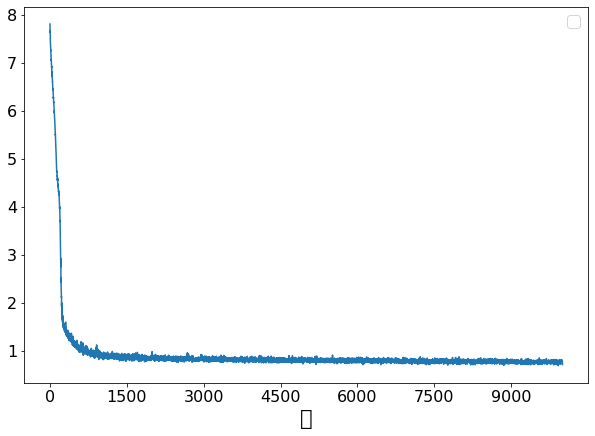

In [33]:
losses = DMM_dics["losses"]
Ver = 6
Hor = 9
fig = plt.figure(figsize=(Hor, Ver))
plt.subplots_adjust(left=0.08, right=0.95, bottom=0.08, top=0.95)
FS = 16
plt.rcParams["font.size"] = FS
plt.plot(losses)
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("Epochs", fontsize=FS+5)
plt.legend()

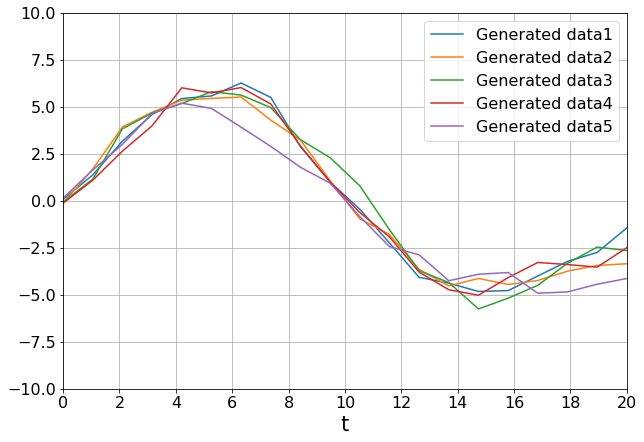

In [28]:
which_mini_batch = 0
training_seq_lengths = torch.tensor([length]*N_songs)
data_dim = training_data_sequences.size(-1)

N_train_data = len(training_seq_lengths)
N_train_time_slices = float(torch.sum(training_seq_lengths))
N_mini_batches = int(N_train_data / mini_batch_size +
                int(N_train_data % mini_batch_size > 0))
shuffled_indices = torch.randperm(N_train_data)
mini_batch_start = (which_mini_batch * mini_batch_size)
mini_batch_end = np.min([(which_mini_batch + 1) * mini_batch_size, N_train_data])
mini_batch_indices = shuffled_indices[mini_batch_start:mini_batch_end]

# grab a fully prepped mini-batch using the helper function in the data loader
mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths \
    = poly.get_mini_batch(mini_batch_indices, training_data_sequences,
                            training_seq_lengths, cuda=cuda)

pos_z, pos_z_loc, pos_z_scale = encoder(mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths)
pri_z, pri_z_loc, pri_z_scale = prior(length = mini_batch.size(1), N_generate= mini_batch.size(0))

path = os.path.join("saveData", "Experiments", "No3")
os.makedirs(path, exist_ok=True)

Ver = 6
Hor = 9
fig = plt.figure(figsize=(Hor, Ver))
plt.subplots_adjust(left=0.08, right=0.95, bottom=0.08, top=0.95)
FS = 16
plt.rcParams["font.size"] = FS
x = np.linspace(0, length, length)
for i in range(N_songs):
    plt.plot(x, decoder(pri_z)[i].detach().numpy(), label="Generated data" + str(i+1))
plt.grid()
plt.ylim(top=10, bottom=-10)
plt.xlim(0, length)
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("t", fontsize=FS+5)
plt.legend()

In [ ]:
which_mini_batch = 0
training_seq_lengths = torch.tensor([length]*N_songs)
data_dim = training_data_sequences.size(-1)

N_train_data = len(training_seq_lengths)
N_train_time_slices = float(torch.sum(training_seq_lengths))
N_mini_batches = int(N_train_data / mini_batch_size +
                int(N_train_data % mini_batch_size > 0))
shuffled_indices = torch.randperm(N_train_data)
mini_batch_start = (which_mini_batch * mini_batch_size)
mini_batch_end = np.min([(which_mini_batch + 1) * mini_batch_size, N_train_data])
mini_batch_indices = shuffled_indices[mini_batch_start:mini_batch_end]

# grab a fully prepped mini-batch using the helper function in the data loader
mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths \
    = poly.get_mini_batch(mini_batch_indices, training_data_sequences,
                            training_seq_lengths, cuda=cuda)
def D_KL(p_loc, q_loc, p_scale, q_scale):
    # locは平均, scaleは共分散行列とする。
    # size = [曲数、拍数、88鍵]
    # Determinant of Covariance Matrix
    det_p_scale = torch.prod(p_scale, dim=2)
    det_q_scale = torch.prod(q_scale, dim=2)
    # Dimension of Maltivariate Normal Distribution
    dim = p_loc.size(-1)
    beats = p_loc.size(1)
    songs = p_loc.size(0)
    # Trace of (\Sigma_q^{-1} \Sigma_p)
    trace = torch.sum(p_scale/q_scale, dim = 2)
    # (loc_q - loc_p)^T \Sigma_q (loc_q - loc_p)
    niji = torch.sum((q_loc-p_loc)*(q_loc-p_loc)/q_scale, dim=2)
    # KL-divergence
    KL = 0.5 *(torch.log(det_q_scale) - torch.log(det_p_scale) - dim + trace + niji)
    return KL.sum() / (beats * songs)

def D_Wass(p_loc, q_loc, p_scale, q_scale):
    # locは平均, scaleは共分散行列とする。
    # size = [曲数、拍数、88鍵]
    beats = p_loc.size(1)
    songs = p_loc.size(0)
    # Determinant of Covariance Matrix
    norm_2 = torch.sum((p_loc - q_loc)*(p_loc - q_loc), dim=2)
    # Dimension of Maltivariate Normal Distribution
    trace_p_scale = torch.sum(p_scale, dim=2)
    trace_q_scale = torch.sum(q_scale, dim=2)
    trace = torch.sum(torch.sqrt(p_scale*q_scale), dim=2)
    # KL-divergence
    Wass = torch.sqrt(norm_2 + trace_p_scale + trace_q_scale - 2 * trace)
    return Wass.sum() / (beats * songs)
    
# generate mini batch from training mini batch
# NaN_detect(dmm, epoch, message="Before Generate")
# with torch.autograd.detect_anomaly():
#     pos_z, pos_z_loc, pos_z_scale = encoder(mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths)
#     pri_z, pri_z_loc, pri_z_scale = prior(length = mini_batch.size(1), N_generate= mini_batch.size(0))

#     loss = 0
#     reconed_x = decoder(pos_z)
#     # Reconstruction Error
#     reconstruction_error = torch.norm(mini_batch - reconed_x, dim=2).sum()/mini_batch.size(0)/mini_batch.size(1)/mini_batch.size(2)
#     # Regularizer (KL-diveergence(pos||pri))
#     regularizer = D_KL(pos_z_loc, pri_z_loc, pos_z_scale, pri_z_scale)

#     loss += reconstruction_error + 0.11 * regularizer

#     optimizer.zero_grad()
#     print(reconstruction_error)
#     print(regularizer)
#     loss.backward()
pos_z, pos_z_loc, pos_z_scale = encoder(mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths)
pri_z, pri_z_loc, pri_z_scale = prior(length = mini_batch.size(1), N_generate= mini_batch.size(0))

loss = 0
reconed_x = decoder(pos_z)
# Reconstruction Error
reconstruction_error = torch.norm(mini_batch - reconed_x, dim=2).sum()/mini_batch.size(0)/mini_batch.size(1)/mini_batch.size(2)
# Regularizer (KL-diveergence(pos||pri))
regularizer = D_Wass(pos_z_loc, pri_z_loc, pos_z_scale, pri_z_scale)
# regularizer = D_Wass(pos_z_loc, pos_z_loc, pos_z_scale, pos_z_scale)
print(pri_z_loc.size())

loss += reconstruction_error + 0.11 * regularizer

optimizer.zero_grad()
print(reconstruction_error)
print(regularizer)
loss.backward()
# torch.nn.utils.clip_grad_norm_(params, 1.)

torch.Size([3, 20, 100])
tensor(0.0086, grad_fn=<DivBackward0>)
tensor(2.9669, grad_fn=<DivBackward0>)


In [14]:
def D_Wass(p_loc, q_loc, p_scale, q_scale):
    # locは平均, scaleは共分散行列とする。
    # size = [曲数、拍数、88鍵]
    beats = p_loc.size(1)
    songs = p_loc.size(0)
    # Determinant of Covariance Matrix
    norm_2 = torch.sum((p_loc - q_loc)*(p_loc - q_loc), dim=2)
    print(norm_2.size())
    # Dimension of Maltivariate Normal Distribution
    trace_p_scale = torch.sum(p_scale, dim=2)
    trace_q_scale = torch.sum(q_scale, dim=2)
    trace = torch.sum(torch.sqrt(p_scale*q_scale), dim=2)
    # KL-divergence
    Wass = torch.sqrt(norm_2 + trace_p_scale + trace_q_scale - 2 * trace)
    return Wass.sum() / (beats * songs)

def multi_normal_prob(loc,scale,x):
    # locは平均, scaleは共分散行列, xはサンプルとする。
    pi_2_d = torch.tensor(np.sqrt((np.pi * 2) ** loc.size(-1)))
    det = torch.sum(scale, dim=2)
    # mom = torch.sqrt(det) * pi_2_d
    mom = torch.sqrt(det)
    exp_arg = -0.5 * torch.sum((x-loc) * (x-loc) / scale, dim=2)
    return torch.exp(exp_arg) / mom

def D_JS_Monte(p_loc, q_loc, p_scale, q_scale, x_p, x_q):
    N_data_inverse = 1/(x_p.size(0) + x_q.size(0))
    length = x_p.size(1)
    eps = 1e-40
    p_prob_x_p = multi_normal_prob(p_loc,p_scale,x_p)
    q_prob_x_p = multi_normal_prob(q_loc,q_scale,x_p)
    p_prob_x_q = multi_normal_prob(p_loc,p_scale,x_q)
    q_prob_x_q = multi_normal_prob(q_loc,q_scale,x_q)
    m_prob_x_p = 0.5 * (p_prob_x_p + q_prob_x_p)
    m_prob_x_q = 0.5 * (p_prob_x_q + q_prob_x_q)
    KL_p_m = N_data_inverse * (p_prob_x_p*(torch.log(p_prob_x_p + eps) - torch.log(m_prob_x_p + eps)) + \
        p_prob_x_q*(torch.log(p_prob_x_q + eps) - torch.log(m_prob_x_q + eps)))
    KL_q_m = N_data_inverse * (q_prob_x_p*(torch.log(q_prob_x_p + eps) - torch.log(m_prob_x_p + eps)) + \
        q_prob_x_q*(torch.log(q_prob_x_q + eps) - torch.log(m_prob_x_q + eps)))
    return torch.sum(0.5 * (KL_p_m + KL_q_m) / length)

regularizer = D_Wass(pos_z_loc, pri_z_loc, pos_z_scale, pri_z_scale)
print(regularizer)
print(D_JS_Monte(pos_z_loc, pos_z_loc, pos_z_scale, pos_z_scale, pos_z, pri_z))

torch.Size([3, 20])
tensor(14.6099, grad_fn=<DivBackward0>)
tensor(0., grad_fn=<SumBackward0>)


In [15]:
for para in optimizer.param_groups[0]['params']:
    if para.grad == None:
        continue
    print(any(torch.isnan(para.grad.reshape(-1))), end="")
    if any(torch.isnan(para.grad.reshape(-1))):
        print(para.grad)

FalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalse

In [16]:
print(pos_z_loc.max())
print(pos_z_loc.min())
print(pos_z_scale.max())
print(pos_z_scale.min())
print(pri_z_loc.max())
print(pri_z_loc.min())
print(pri_z_scale.max())
print(pri_z_scale.min())

tensor(2.1837, grad_fn=<MaxBackward1>)
tensor(-1.3057, grad_fn=<MinBackward1>)
tensor(0.0043, grad_fn=<MaxBackward1>)
tensor(3.8874e-05, grad_fn=<MinBackward1>)
tensor(5.8759, grad_fn=<MaxBackward1>)
tensor(-3.7981, grad_fn=<MinBackward1>)
tensor(1., grad_fn=<MaxBackward1>)
tensor(1., grad_fn=<MinBackward1>)


In [17]:
optimizer.step()

In [18]:
for para in optimizer.param_groups[0]['params']:
    print(any(torch.isnan(para.reshape(-1))), end="")

FalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalse

In [19]:
def D_Wass(p_loc, q_loc, p_scale, q_scale):
    # locは平均, scaleは共分散行列とする。
    # size = [曲数、拍数、88鍵]
    beats = p_loc.size(1)
    songs = p_loc.size(0)
    # Determinant of Covariance Matrix
    norm_2 = torch.sum((p_loc - q_loc)*(p_loc - q_loc), dim=2)
    # Dimension of Maltivariate Normal Distribution
    trace_p_scale = torch.sum(p_scale, dim=2)
    trace_q_scale = torch.sum(q_scale, dim=2)
    trace = torch.sum(torch.sqrt(p_scale*q_scale), dim=2)
    # KL-divergence
    Wass = torch.sqrt(norm_2 + trace_p_scale + trace_q_scale - 2 * trace)
    return Wass.sum() / (beats * songs)

In [1]:
torch.log(torch.tensor(0.1))

NameError: name 'torch' is not defined

In [20]:
loc =[]
loc.append(torch.ones(20,100) + 0)
loc.append(torch.ones(20,100) + 1)
loc.append(torch.ones(20,100) + 2)
p_loc = torch.stack(loc)
p_scale = torch.ones(3,20,100)

loc =[]
loc.append(torch.ones(20,100) + 0)
loc.append(torch.ones(20,100) + 1)
loc.append(torch.ones(20,100) + 2)
q_loc = torch.stack(loc)
q_scale = torch.ones(3,20,100)

print(D_Wass(p_loc, q_loc, p_scale, q_scale))

tensor(0.)
